# Install vit_keras

# Import modules

In [1]:
import tensorflow as tf
from tensorflow.keras import backend, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

from vit_keras import vit

# GPU setting

# Prepare generators

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


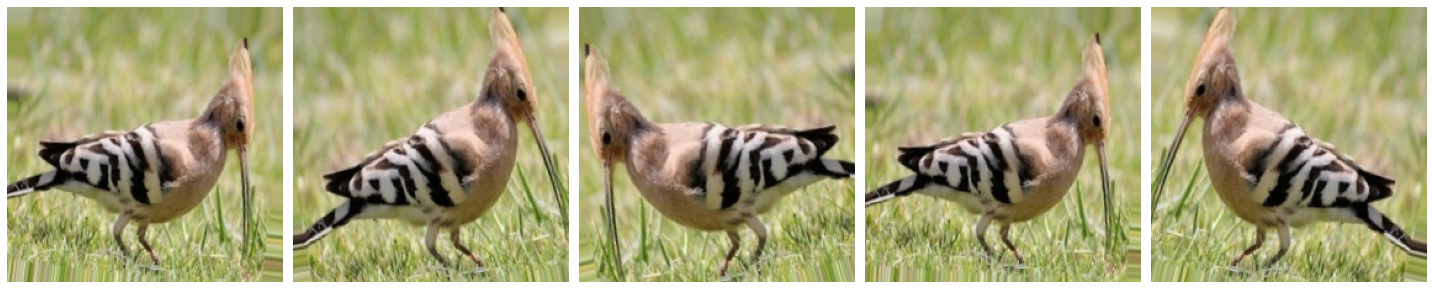

In [3]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse')


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Load pre-trained ViT Model

In [4]:
backend.clear_session()

vit_model = vit.vit_l32(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

print(len(vit_model.layers))
print(vit_model.layers)

2022-05-01 22:29:18.907710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 22:29:18.908011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



/Users/shaun/miniforge3/lib/python3.9/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


31
[<keras.engine.input_layer.InputLayer object at 0x16ac523d0>, <keras.layers.convolutional.Conv2D object at 0x17fa74bb0>, <keras.layers.core.reshape.Reshape object at 0x2a2887250>, <vit_keras.layers.ClassToken object at 0x2a2887970>, <vit_keras.layers.AddPositionEmbs object at 0x2ae0cce80>, <vit_keras.layers.TransformerBlock object at 0x2afb06e80>, <vit_keras.layers.TransformerBlock object at 0x2afb0ee50>, <vit_keras.layers.TransformerBlock object at 0x2afb8ed00>, <vit_keras.layers.TransformerBlock object at 0x2b9d73be0>, <vit_keras.layers.TransformerBlock object at 0x2c0f02040>, <vit_keras.layers.TransformerBlock object at 0x2c3f857f0>, <vit_keras.layers.TransformerBlock object at 0x2c1b5ff70>, <vit_keras.layers.TransformerBlock object at 0x2c72a0850>, <vit_keras.layers.TransformerBlock object at 0x2cd42cc10>, <vit_keras.layers.TransformerBlock object at 0x2cdcae520>, <vit_keras.layers.TransformerBlock object at 0x2cdcbd8e0>, <vit_keras.layers.TransformerBlock object at 0x2d36258e0>

# Learning Scheduler

In [5]:
# Decay lr for each 7 epochs
def scheduler(epoch: int, lr: float) -> float:
    if epoch != 0 and epoch % 7 == 0:
        return lr * 0.1
    else:
        return lr
lr_scheduler_callback = LearningRateScheduler(scheduler)

# Build model and train model

In [6]:
finetune_at = 28

# fine-tuning
for layer in vit_model.layers[:finetune_at - 1]:
    layer.trainable = False
    
num_classes = len(validation_generator.class_indices)

# Add GaussianNoise layer for robustness
noise = GaussianNoise(0.01, input_shape=(224, 224, 3))
# Classification head
head = Dense(num_classes, activation="softmax")

model = Sequential()
model.add(noise)
model.add(vit_model)
model.add(head)

model.compile(optimizer=optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
                      
history = model.fit(
          train_generator,
          epochs=100,
          validation_data=validation_generator,
          verbose=1, 
          shuffle=True,
          callbacks=[
              EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
              lr_scheduler_callback,
          ])

Epoch 1/100


2022-05-01 22:29:25.176714: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 22:29:34.295476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9362

2022-05-01 22:33:03.208152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 231s 2s/step - loss: 0.2241 - accuracy: 0.9362 - val_loss: 0.0130 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/100
96/96 [==============================] - 296s 3s/step - loss: 0.0403 - accuracy: 0.9895 - val_loss: 0.0092 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/100
96/96 [==============================] - 372s 4s/step - loss: 0.0240 - accuracy: 0.9934 - val_loss: 0.0032 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/100
96/96 [==============================] - 398s 4s/step - loss: 0.0477 - accuracy: 0.9868 - val_loss: 0.0134 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/100
96/96 [==============================] - 410s 4s/step - loss: 0.0282 - accuracy: 0.9931 - val_loss: 0.0163 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 6/100
96/96 [==============================] - 377s 4s/step - loss: 0.0128 - accuracy: 0.9980 - val_loss: 0.0252 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/100
96/96 [==============================] - 369s 4s/step - loss: 0.0163 -

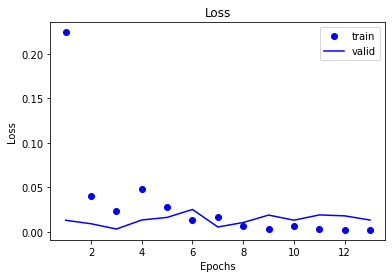

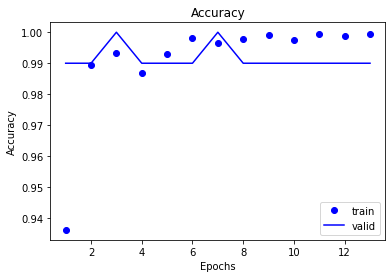

best val_acc: 1.0 epoch: 2
best val_loss: 0.003218580735847354 epoch: 2


In [7]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]
epochs = range(1, len(history_dict["accuracy"]) + 1)

plt.plot(epochs, loss_values, "bo", label="train")
plt.plot(epochs, val_loss_values, "b", label="valid")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, acc_values, "bo", label="train")
plt.plot(epochs, val_acc_values, "b", label="valid")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

import numpy as np
print("best val_acc:", np.max(val_acc_values), "epoch:", np.argmax(val_acc_values))
print("best val_loss:", np.min(val_loss_values), "epoch:", np.argmin(val_loss_values))

# testing

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 5s 1s/step - loss: 0.0882 - accuracy: 0.9900
Test Accuracy: 0.9899999499320984


In [9]:
model.save("./models/vit_l32_finetuned.h5")

In [10]:
model.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 224, 224, 3)      0         
 se)                                                             
                                                                 
 vit-l32 (Functional)        (None, 1024)              305510400 
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                                 
Total params: 305,530,900
Trainable params: 25,214,996
Non-trainable params: 280,315,904
_________________________________________________________________
